In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util_old as pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot


Populating the interactive namespace from numpy and matplotlib


In [72]:
#define functions
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
    
def process_sample(dir_trail,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(len(allfname_trail)):
        R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
        phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
        z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
        vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
        vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
        vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
        t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
        
    for ii in range(len(allfname_lead)):
        R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
        phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
        z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
        vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
        vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
        vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
        t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
    
    o_t=[]
    ts_t=[]
    o_l=[]
    ts_l=[]
    
   
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
        
    else : 
        print ("acceptable output format : radec or xieta")

        
        
def include_both_arms(xi_t,eta_t,xi_l,eta_l):
    min_eta_t=min(eta_t)
    max_eta_t=max(eta_t)

    xi_l_select=[]
    eta_l_select=[]

    for jj in range(len(eta_l)):
        if min_eta_t <= eta_l[jj] <= max_eta_t :
            xi_l_select.append(xi_l[jj])
            eta_l_select.append(eta_l[jj])

    print (len(xi_l), len(xi_l_select))

    plt.figure()
    plt.scatter(xi_l_select,eta_l_select)
    plt.show()
    
    xi_all = np.concatenate((xi_t,xi_l_select))
    
    return xi_all

def compute_length(Ndn,sNdn,midxi,max_midxi=3.,minxi=0.25,maxxi=14.35,frac=0.2):
    
       
    sNdn_select = []
    for jj in range(len(midxi)):
        if midxi[jj] < max_midxi :
            sNdn_select.append(sNdn[jj])
        
    sNdn_select=np.array(sNdn_select)
    mean_Ndn=np.mean(sNdn_select)

    ind=[]
    for ii in range(len(midxi)):
        #print (Ndn[ii],0.2*sNdn[ii])
        if Ndn[ii]<= mean_Ndn*frac:
            
            ind.append(ii)
    
    if len(ind) != 0 :
        maxxi=midxi[min(ind)]
    
    return maxxi-minxi


def compute_SNdnxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3):
    N=len(xi)
    print (N)
    
    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
               
    return (midxi,Ndn)
        

def compute_Ndnxi(xi,sNdn,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,ylim_max=1500.,label='',fname=''):
    N=len(xi)
    print (N)
    
    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    length=compute_length(Ndn,sNdn,midxi,max_midxi=3.,minxi=0.25,maxxi=14.35,frac=0.2)
           
    if plot :
            plt.figure(figsize=(20,10))
            plt.title('stream length = %.1f deg'%length)
            plt.plot(midxi,Ndn,ls='steps-mid',label=label)
            plt.ylim(0.,ylim_max)
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('Star count',fontsize=18)
            plt.legend(loc='upper right',fontsize=18)
               
            if fname != '' :
                plt.savefig(fname)
            
            plt.show()
            
    return (midxi,Ndn)


## Smooth stream

101000 100107


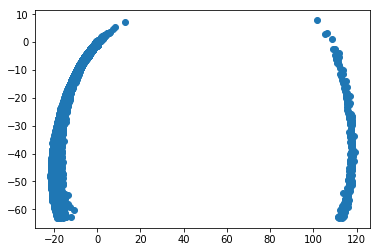

201107
no of xi bins = 141
79813


In [91]:
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_spraydf_nobarpot/trailing/'
sxi_t,seta_t,sxi_l,seta_l=process_sample(dir,out_format='xieta')

sxi = include_both_arms(sxi_t,seta_t,sxi_l,seta_l)

smidxi,sNdn = compute_SNdnxi(sxi,minxi=0.25,maxxi=14.35,bw=0.1)


101000 98001


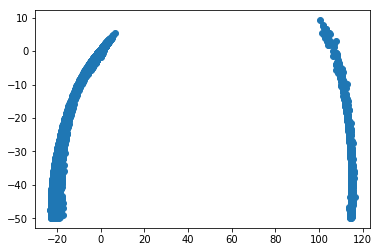

199001
no of xi bins = 141
81594


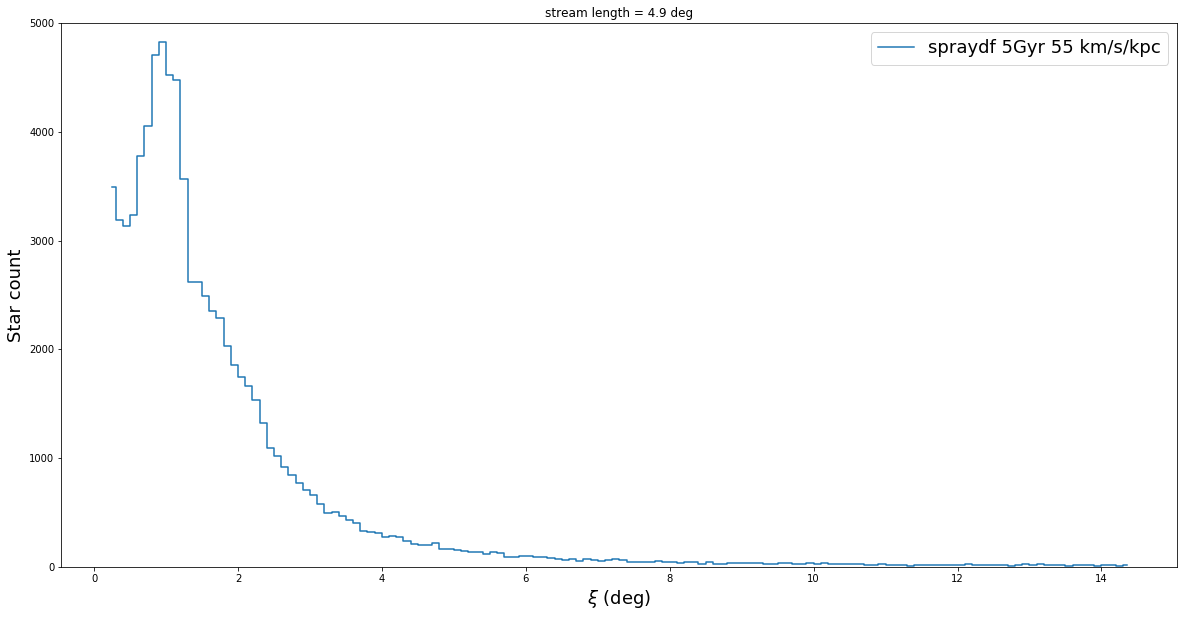

In [116]:
Om=55
method='spraydf'

dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_5Gyr_'+method+'_patspeed{}/trailing/'.format(Om)
xi_t,eta_t,xi_l,eta_l=process_sample(dir1,out_format='xieta')

xi=include_both_arms(xi_t,eta_t,xi_l,eta_l)

midxi,Ndn = compute_Ndnxi(xi,sNdn,minxi=0.25,maxxi=14.35,bw=0.1,ylim_max=5000.,label= method+ ' 5Gyr {} km/s/kpc'.format(Om),
                                    fname='plots/nden_'+method+'_5Gyr_patspeed{}.pdf'.format(Om))


In [ ]:
print (compute_length(Ndn,sNdn,midxi,max_midxi=3.,minxi=0.25,maxxi=14.35,frac=0.2))

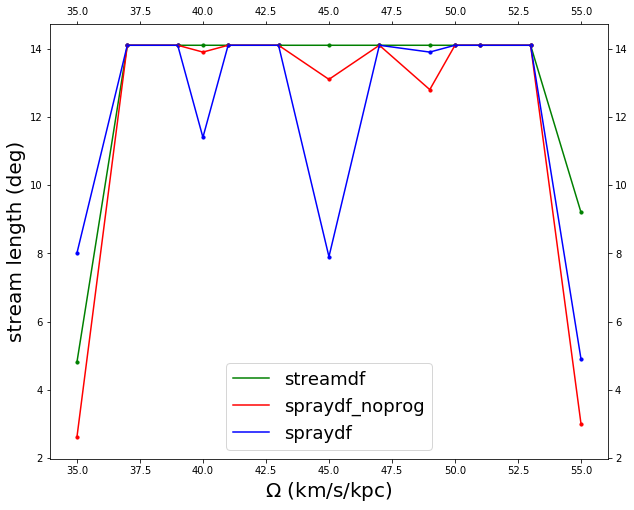

In [128]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.]

streamdf=[4.8,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,9.2]
spraydf_noprog = [2.6,14.1,14.1,13.9,14.1,14.1,13.1,14.1,12.8,14.1,14.1,14.1,3.0]
spraydf=[8.,14.1,14.1,11.4,14.1,14.1,7.9,14.1,13.9,14.1,14.1,14.1,4.9]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/stream_length_vs_pat_speed.pdf')
plt.show()


